# Chapter 9: Transfer Learning

## Lab 9: Using Inception-v3 for Transfer Learning

This chapter introduces how to use the Inception-v3 network for improving image classification performance on the Dogs vs. Cats dataset. Two scenarios of training the InceptionV3 network are conducted. 


1) In the first scenario, the Inception-v3 model is built through Keras Applications and trained from scratch with random weight initialization, named Model-1. 

2) In the second scenario, a new network model is built by using the first half of the pre-trained Inception-v3 network for feature extraction and adopting two fully connected layers for classification, called Model-2. 

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://github.com/taipeitechmmslab/MMSLAB-DL/blob/master/Lab9.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

### 1.	Preparing Dataset

a)	Import packages

In [2]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from preprocessing import flip, color, rotate, zoom

b)	Loading data

### cats_vs_dogs

•	Load Cats_vs_Dog dataset:

In [3]:
# dividing data: 80% for training, 10% for validation, and 10% for testing
train_split, valid_split, test_split = ['train[:80%]', 'train[80%:90%]', 'train[90%:]']
# load the training set
train_data, info = tfds.load("cats_vs_dogs", split=train_split, with_info=True)
# load validation set
valid_data = tfds.load("cats_vs_dogs", split=valid_split)
# load test set
test_data = tfds.load("cats_vs_dogs", split=test_split)

Shuffling and writing examples to C:\/Users/hieu/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteNC1E02/cats_vs_dogs-train.tfrecord


Dataset cats_vs_dogs downloaded and prepared to C:\Users\hieu\tensorflow_datasets\cats_vs_dogs\4.0.0. Subsequent calls will reuse this data.


•	View name of class and create decoder:

In [5]:
print(info.features['label'].names)
decoder = info.features['label'].names

['cat', 'dog']


•	Display the image from dataset:

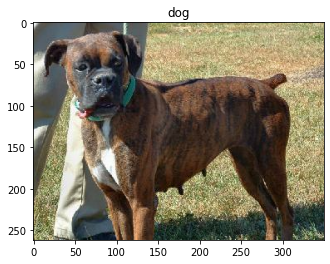

In [6]:
for data in train_data.take(1):
    img = data['image']  # image
    label = data['label'] # lable
# get the class
plt.title(decoder[label])
# Display image
plt.imshow(img)

### c)	Setting data

•	Creating function for data augmentation:


In [9]:
input_shape = (299, 299)

In [10]:
# image augmentation (for training)
def parse_aug_fn(dataset):
    """
    Image Augmentation(影像增強) function
    """
    x = tf.cast(dataset['image'], tf.float32) / 255.  #Image standardization
    x = tf.image.resize(x, input_shape)
    x = flip(x)  # Random horizontal flip
    # color conversion (50%)
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: color(x), lambda: x)
    # Image rotation (25%)
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.75, lambda: rotate(x), lambda: x)
    # image scaling (50%)
    x = tf.cond(tf.random.uniform([], 0, 1) > 0.5, lambda: zoom(x), lambda: x)
    return x, dataset['label']

# without image augmentation (for testing)
def parse_fn(dataset):
    x = tf.cast(dataset['image'], tf.float32) / 255. 
    x = tf.image.resize(x, input_shape)
    return x, dataset['label']

•	Setting data for training, validation, and testing:

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE # Automatic adjustment mode
buffer_size = 1000  # Because the image is larger, the cache space is set to 1000.
bacth_size = 32  # Batch size

# Training data
train_data = train_data.map(map_func=parse_aug_fn, num_parallel_calls=AUTOTUNE)
train_data = train_data.shuffle(buffer_size)  # shuffle training data
# Set batch size and turn on prefetch mode 
train_data = train_data.batch(bacth_size).prefetch(buffer_size=AUTOTUNE)

# Validation data
valid_data = valid_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# Set batch size and turn on prefetch mode 
valid_data = valid_data.batch(bacth_size).prefetch(buffer_size=AUTOTUNE)

# Test data
test_data = test_data.map(map_func=parse_fn, num_parallel_calls=AUTOTUNE)
# Set batch size and turn on prefetch mode
test_data = test_data.batch(bacth_size).prefetch(buffer_size=AUTOTUNE)

### 2.	Building and training network models

### a)	Model-1: Training from scratch (Random Initialization)


•	Create a storage directory for saving model:

In [13]:
model_dir = 'lab9-logs/models'  # set storage directory path 
os.makedirs(model_dir)  # Create a storage directory

•	Set callback function:

In [14]:
# Save training log
log_dir = os.path.join('lab9-logs', 'model-1')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)

model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-1.h5', 
                                             monitor='val_binary_accuracy', 
                                             save_best_only=True, 
                                             mode='max')
# early stopping during training
model_esp = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20)

•	Create InceptionV3 network:

In [15]:
# Loading InceptionV3 network from keras.applications  
base_model = tf.keras.applications.InceptionV3(include_top=False, 
                                               weights=None, 
                                               pooling='avg', 
                                               input_shape=input_shape+(3,))
# adding two fully connected layers to top of the base InceptionV3 model, 
# using the Sigmoid activation function in the last layer
model_1 = tf.keras.Sequential([
    base_model,
    layers.Dense(128, activation='relu'), 
    layers.Dense(1, activation='sigmoid')
])


•	View model information via “model.summary” API:

In [16]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2048)              21802784  
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 22,065,185
Trainable params: 22,030,753
Non-trainable params: 34,432
_________________________________________________________________


•	Set the optimizer, loss function, and metric function:

In [17]:
model_1.compile(keras.optimizers.Adam(), 
                loss=keras.losses.BinaryCrossentropy(), 
                metrics=[keras.metrics.BinaryAccuracy()])

•	Training model-1

In [13]:
history = model_1.fit(train_data,
                      epochs=200, 
                      validation_data=valid_data,
                      callbacks=[model_cbk, model_mckp, model_esp])

Epoch 1/200


W0716 10:48:04.863682 139754391103296 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


582/582 [==============================] - 381s 655ms/step - loss: 0.6649 - binary_accuracy: 0.6150 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00
Epoch 2/200
582/582 [==============================] - 285s 489ms/step - loss: 0.5869 - binary_accuracy: 0.6902 - val_loss: 0.6301 - val_binary_accuracy: 0.6853
Epoch 3/200
582/582 [==============================] - 286s 492ms/step - loss: 0.5339 - binary_accuracy: 0.7364 - val_loss: 0.8289 - val_binary_accuracy: 0.7207
Epoch 4/200
582/582 [==============================] - 282s 484ms/step - loss: 0.4765 - binary_accuracy: 0.7767 - val_loss: 0.4959 - val_binary_accuracy: 0.7845
Epoch 5/200
582/582 [==============================] - 281s 483ms/step - loss: 0.3897 - binary_accuracy: 0.8239 - val_loss: 0.3741 - val_binary_accuracy: 0.8642
Epoch 6/200
582/582 [==============================] - 279s 479ms/step - loss: 0.3207 - binary_accuracy: 0.8579 - val_loss: 0.6759 - val_binary_accuracy: 0.7905
Epoch 7/200
582/582 [=================

### b)	Model-2: Transfer Learning

•	Set callback function:

In [13]:
# Save training log
log_dir = os.path.join('lab9-logs', 'model-2')
model_cbk = keras.callbacks.TensorBoard(log_dir=log_dir)
model_mckp = keras.callbacks.ModelCheckpoint(model_dir + '/Best-model-2.h5', 
                                             monitor='val_binary_accuracy', 
                                             save_best_only=True, 
                                             mode='max')
# early stopping during training
model_esp = keras.callbacks.EarlyStopping(monitor='val_binary_accuracy', patience=20, mode='max')

•	Create new network model based on InceptionV3 architecture:

In [18]:
module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

# Create a new network model based on InceptionV3
model_2 = tf.keras.Sequential([
    # loading the first half of the Inception-v3 network and encapsulating it into a network layer (Keras Layer)
    hub.KerasLayer(module_url,
                   input_shape=(299, 299, 3),  
                   output_shape=(2048,),   
                   trainable=False),  
    # add two fully connected layers, and use the Sigmoid activation function at the last layer.
    layers.Dense(128, activation='relu'), 
    layers.Dense(1, activation='sigmoid')
])


•	View model information via “model.summary”:

In [19]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
dense_2 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 22,065,185
Trainable params: 262,401
Non-trainable params: 21,802,784
_________________________________________________________________


•	Set the optimizer, loss function, and metric function:

In [16]:
model_2.compile(keras.optimizers.Adam(), 
               loss=keras.losses.BinaryCrossentropy(), 
               metrics=[keras.metrics.BinaryAccuracy()])

•	Training model-2

In [18]:
history = model_2.fit(train_data,
                      epochs=200, 
                      validation_data=valid_data,
                      callbacks=[model_cbk, model_esp, model_mckp])

Epoch 1/200
582/582 [==============================] - 92s 158ms/step - loss: 0.0799 - binary_accuracy: 0.9736 - val_loss: 0.0000e+00 - val_binary_accuracy: 0.0000e+00
Epoch 2/200
582/582 [==============================] - 89s 153ms/step - loss: 0.0551 - binary_accuracy: 0.9800 - val_loss: 0.0162 - val_binary_accuracy: 0.9931
Epoch 3/200
582/582 [==============================] - 88s 152ms/step - loss: 0.0502 - binary_accuracy: 0.9825 - val_loss: 0.0168 - val_binary_accuracy: 0.9922
Epoch 4/200
582/582 [==============================] - 88s 151ms/step - loss: 0.0474 - binary_accuracy: 0.9823 - val_loss: 0.0404 - val_binary_accuracy: 0.9849
Epoch 5/200
582/582 [==============================] - 89s 152ms/step - loss: 0.0521 - binary_accuracy: 0.9812 - val_loss: 0.0141 - val_binary_accuracy: 0.9944
Epoch 6/200
582/582 [==============================] - 88s 152ms/step - loss: 0.0455 - binary_accuracy: 0.9827 - val_loss: 0.0160 - val_binary_accuracy: 0.9931
Epoch 7/200
582/582 [===========

### 3.	Comparison of Model-1 and Model-2

In [19]:
model_1.load_weights(model_dir + '/Best-model-1.h5')
model_2.load_weights(model_dir + '/Best-model-2.h5')

In [20]:
loss_1, acc_1 = model_1.evaluate(test_data)
loss_2, acc_2 = model_2.evaluate(test_data)

     73/Unknown - 9s 129ms/step - loss: 0.0174 - binary_accuracy: 0.9940

In [21]:
print("Model_1 Prediction: {}%".format(acc_1 * 100))
print("Model_2 Prediction: {}%".format(acc_2 * 100))

Model_1 Prediction: 97.97413945198059%
Model_2 Prediction: 99.39655065536499%


In [22]:
acc_2 - acc_1

0.014224112